In [2]:
import MDAnalysis as mda
from MDAnalysis.lib.distances import distance_array
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.contacts import Contacts
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
from pprint import pprint
from os import path
import datetime

import itertools, shutil
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from PIL import Image

In [2]:
dirpath = '/Users/junealexissantos/Documents/MS Research Data/PRELIM_DATA'
save_loc = "/Users/junealexissantos/Desktop/savepath_interacting_aa/"

if not os.path.exists(save_loc):
    os.mkdir(save_loc)
else:
    print(f"Save Location does exists. Status: {os.path.exists(save_loc)}")


Save Location does exists. Status: True


In [5]:
def aa_converter() -> dict:
    return  {
    "Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C",
    "Glu": "E", "Gln": "Q", "Gly": "G", "His": "H", "Ile": "I",
    "Leu": "L", "Lys": "K", "Met": "M", "Phe": "F", "Pro": "P",
    "Ser": "S", "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V"
}

def get_box_plot(data: dict, save=False, savepath=None, title=None):
    df = pd.DataFrame.from_dict(data)
    arr = df.to_numpy()
    fig, ax = plt.subplots(figsize=(8,2), dpi=180)
    
    sns.boxplot(df, ax=ax, linewidth=0.2, whis=(0, 100))
    ax.tick_params(which='both',axis='x', labelrotation=90)
    ax.tick_params(which='both',axis='both', labelsize=5)
    ax.set_xticks(np.linspace(0,70,8), np.linspace(436,506,8))
    ax.set_ylabel("Residue - Ligand Distance (Å)", fontsize=6)
    ax.set_xlabel("Interacting Residue (Residue ID)", fontsize=6)
    ax.set_title(f"Residue Distance Profile: {title}")
    ax.set_ylim(0,10)
    
    ax.axhline(y=3.0, color='red', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    
    if save:
        overwrite = True
        counter = 1
        while overwrite:
            if os.path.exists(os.path.join(savepath,f'resplot{title}_{counter}.png')):
                print(f"{os.path.join(savepath,f'resplot{title}_{counter}.png')} does exist. Rewinding loop...")
                counter += 1
            else:
                plt.savefig(os.path.join(savepath,f'resplot{title}_{counter}.png'), dpi=300)
                overwrite = False
    plt.show()

def get_heatmap(data: dict, save=False, savepath=None, title=None):
    df = pd.DataFrame.from_dict(data)
    fig, ax = plt.subplots(dpi=180)
    sns.heatmap(df, ax=ax, annot=True)
    ax.tick_params(which='both',axis='x', labelrotation=90)
    ax.tick_params(which='both',axis='both', labelsize=5)
    ax.set_xticks(np.linspace(0,70,8), np.linspace(436,506,8).astype(int))
    ax.set_ylabel("Residue - Ligand Distance (Å)", fontsize=6)
    ax.set_xlabel("Interacting Residue (Residue ID)", fontsize=6)
    ax.set_title(f"Residue Distance Profile: {title}")
    ax.set_ylim(0,10)

    plt.tight_layout()
    
    if save:
        overwrite = True
        counter = 1
        while overwrite:
            if os.path.exists(os.path.join(savepath,f'res_heatmap_{title}_{counter}.png')):
                print(f"{os.path.join(savepath,f'res_heatmap_{title}_{counter}.png')} does exist. Rewinding loop...")
                counter += 1
            else:
                plt.savefig(os.path.join(savepath,f'res_heatmap_{title}_{counter}.png'), dpi=300)
                overwrite = False
    plt.show()
    

def calculate_distance(traj: str, topol: str, runtime_title = None, save=False, savepath=None):
    
    # Load trajectory and topology using MDAnalysis
    u = mda.Universe(topol, traj, topology_format='TPR')
    
    lig_selection = 'resname UNK'
    rec_selection = f'protein and not (resname UNK) and (resid {436-333}:{506-333+1})'

    ligand_atoms = u.select_atoms(lig_selection)
    protein_atoms = u.select_atoms(rec_selection)

    #creating a subselection
    RBM = protein_atoms.residues.resnames
    ls = [aa_converter()[x.title()] for x in protein_atoms.residues.resnames]
    print("Peptide to be calculated from: RBM\n Please make sure the RBM sequence matches (almost)","".join(ls)) #view peptide RBM


    #show title
    if runtime_title is not None:
        print(f"runtime: {datetime.datetime.now()} : {runtime_title}")
    
    #distance array calculation start
    start_timer = time.perf_counter()

    #container
    mindist_matrix = dict()
    for resi in tqdm(range(436-333+1,506-333+1), desc='resi'):
        sub_selection = protein_atoms.select_atoms(f'resid {resi}')
        da = distance_array(sub_selection.positions, ligand_atoms.positions)
        dt_mat = [distance_array(sub_selection.positions, ligand_atoms.positions) for fr in u.trajectory ]
        mindist_matrix[sub_selection.residues.resnames[0]+str(resi+333-1)] = [dts.min() for dts in dt_mat]

    end_timer = time.perf_counter()
    print(f"Calculation end with time: {(end_timer - start_timer):.2f}")


    get_box_plot(mindist_matrix, save=save, savepath=savepath, title=runtime_title)
    get_heatmap(mindist_matrix, save=save, savepath=savepath, title=runtime_title)


In [98]:
#directories
sample_folder = os.path.join(dirpath,"omic_WT_complex")
tpr_files = glob.glob(os.path.join(sample_folder,"*minimization.tpr"))
xtc_files = glob.glob(os.path.join(sample_folder,"*mdout.xtc"))


savepath = "/Users/junealexissantos/Documents/MS Research Data/savepath"

a = calculate_distance(xtc_files[0], tpr_files[0], save=True, savepath=savepath, 
                       runtime_title = os.path.basename(sample_folder).split("_")[-1])

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
runtime: 2024-11-16 16:12:09.778464 : N440K


resi: 100%|█████████████████████████████████████| 70/70 [02:11<00:00,  1.88s/it]


Calculation end with time: 131.89
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotN440K_1.png does exist. Rewinding loop...


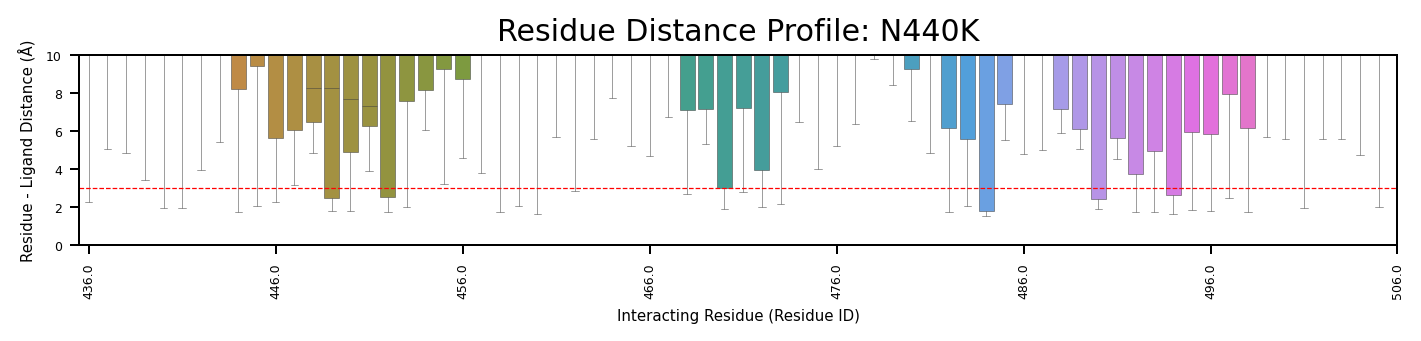

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLRSYGFQPTNGVGYQ
runtime: 2024-11-16 16:14:22.588738 : Q493R


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.90s/it]


Calculation end with time: 132.78
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotQ493R_1.png does exist. Rewinding loop...


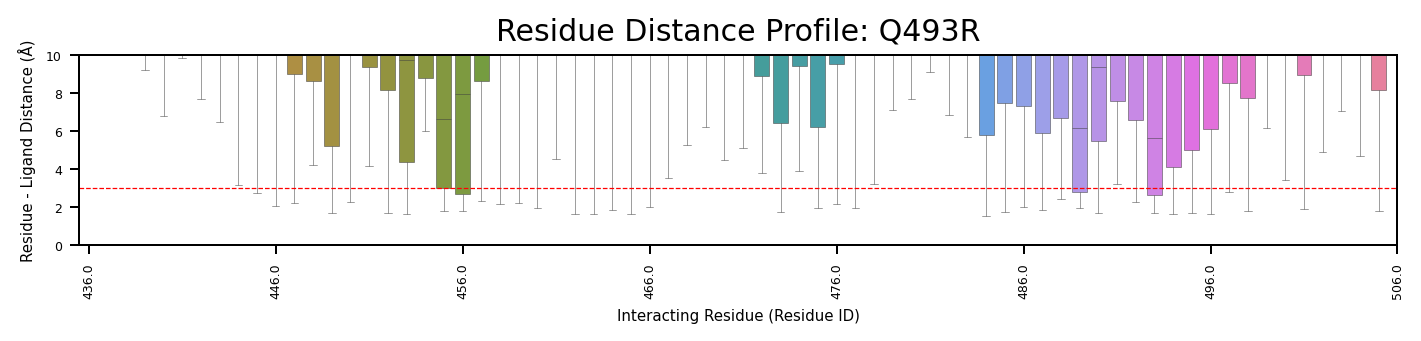

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSKPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
runtime: 2024-11-16 16:16:36.337878 : T478K


resi: 100%|█████████████████████████████████████| 70/70 [02:17<00:00,  1.96s/it]


Calculation end with time: 137.52
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotT478K_1.png does exist. Rewinding loop...


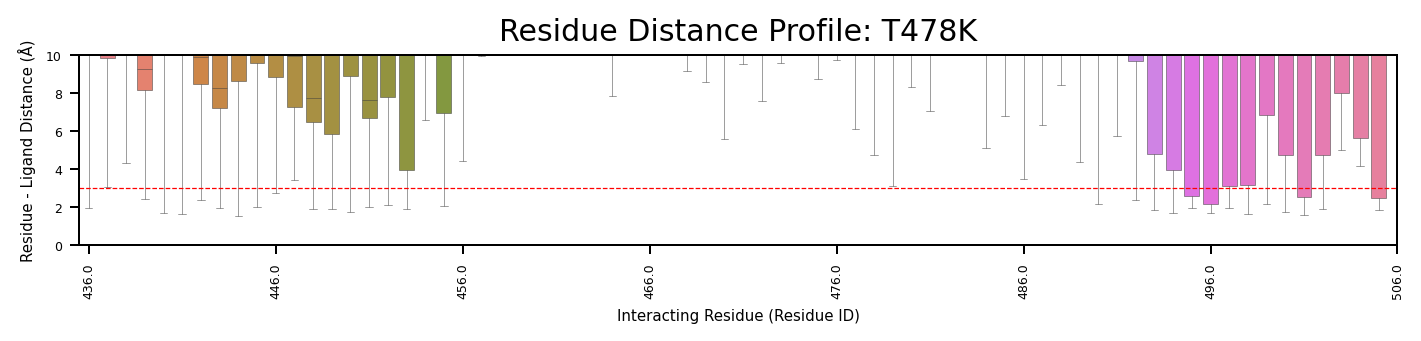

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNKLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNKPCNGVAGFNCYFPLRSYGFRPTYGVGHQ
runtime: 2024-11-16 16:18:54.887894 : complex


resi: 100%|█████████████████████████████████████| 70/70 [02:27<00:00,  2.11s/it]


Calculation end with time: 147.64
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotcomplex_1.png does exist. Rewinding loop...


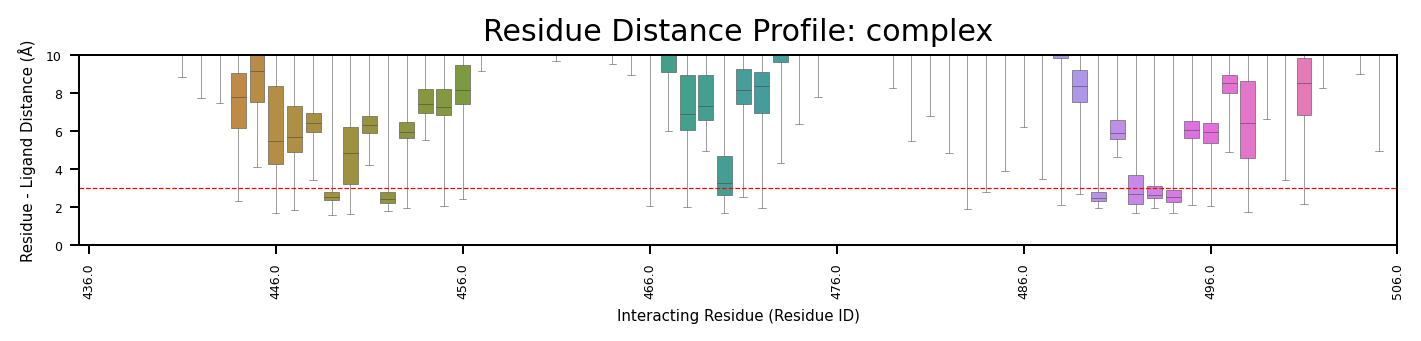

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGNTPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
runtime: 2024-11-16 16:21:23.363970 : S477N


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.90s/it]


Calculation end with time: 132.71
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotS477N_1.png does exist. Rewinding loop...


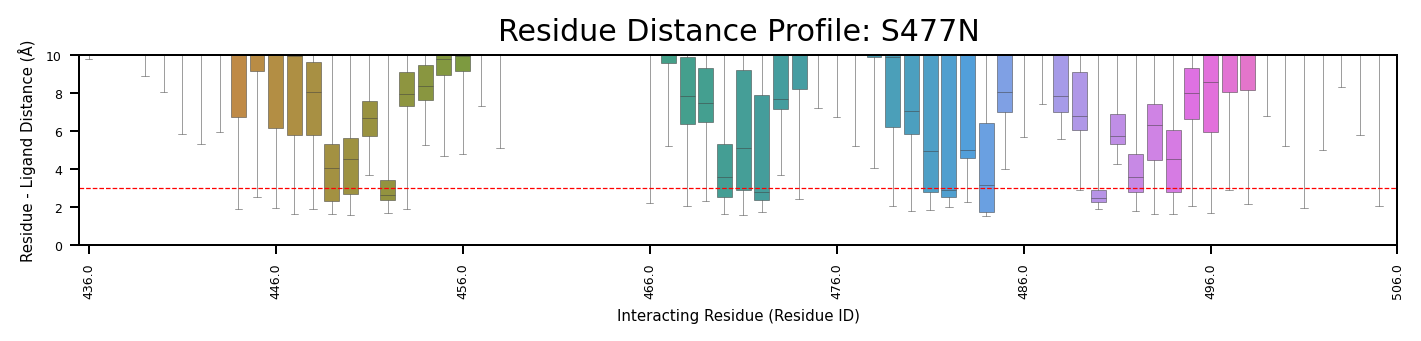

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFRPTNGVGYQ
runtime: 2024-11-16 16:23:37.088476 : Q498R


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.90s/it]


Calculation end with time: 132.87
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotQ498R_1.png does exist. Rewinding loop...


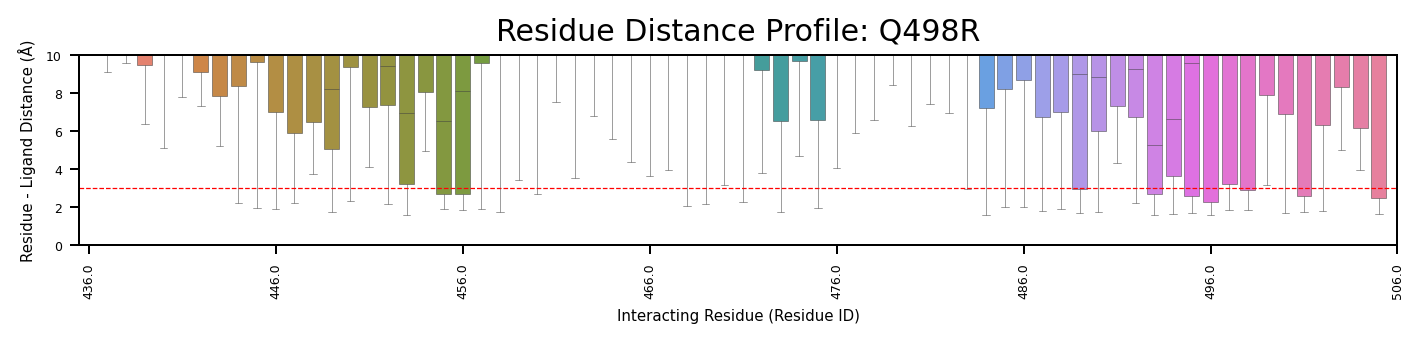

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTYGVGYQ
runtime: 2024-11-16 16:25:50.925695 : N501Y


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.89s/it]


Calculation end with time: 132.47
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotN501Y_1.png does exist. Rewinding loop...


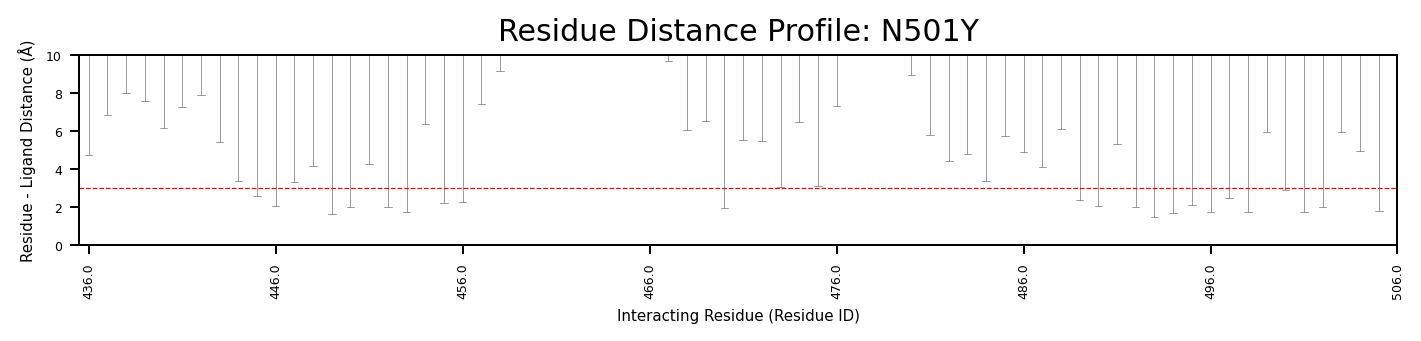

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQ
runtime: 2024-11-16 16:28:04.189235 : complex


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.90s/it]


Calculation end with time: 132.68
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotcomplex_1.png does exist. Rewinding loop...


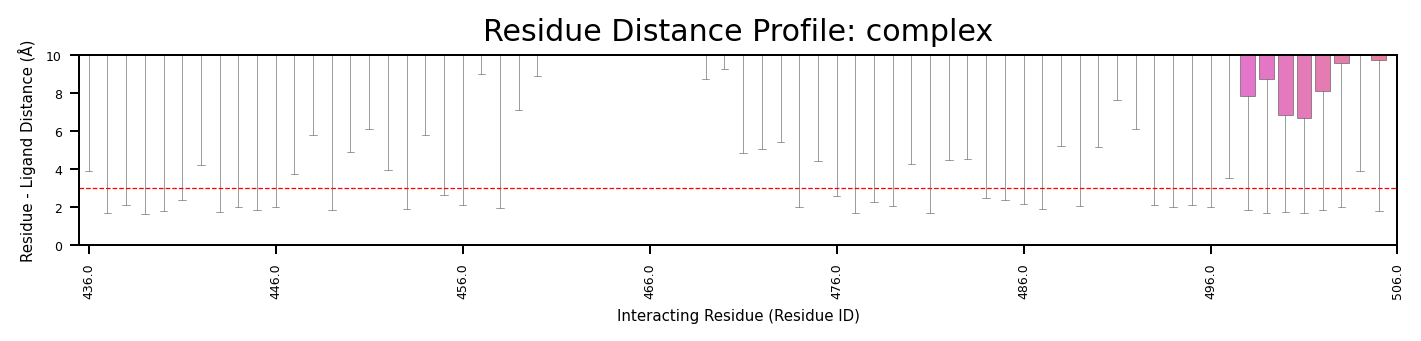

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVAGFNCYFPLQSYGFQPTNGVGYQ
runtime: 2024-11-16 16:30:17.807851 : E484A


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.89s/it]


Calculation end with time: 132.43
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotE484A_1.png does exist. Rewinding loop...


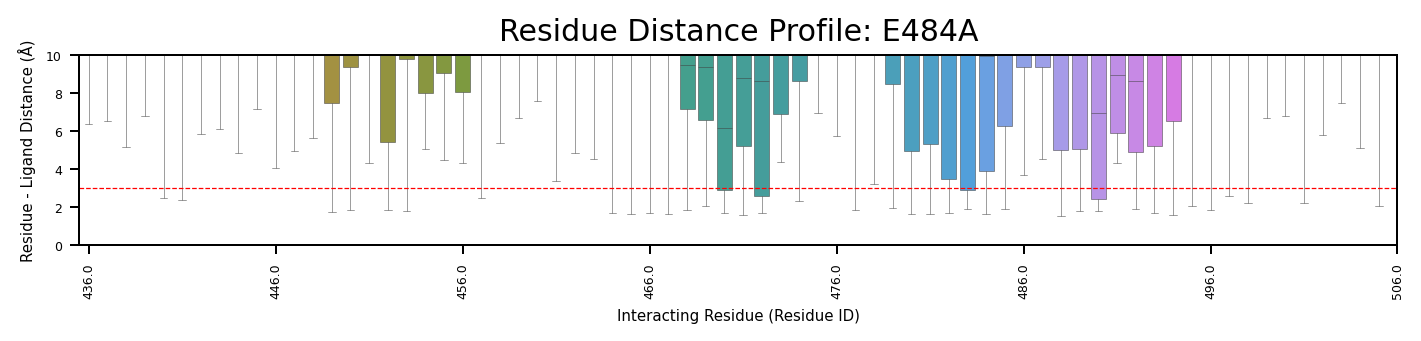

Peptide to be calculated from: RBM
 Please make sure the RBM sequence matches (almost) AWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGHQ
runtime: 2024-11-16 16:32:31.129931 : Y505H


resi: 100%|█████████████████████████████████████| 70/70 [02:12<00:00,  1.89s/it]


Calculation end with time: 132.53
/Users/junealexissantos/Documents/MS Research Data/savepath/resplotY505H_1.png does exist. Rewinding loop...


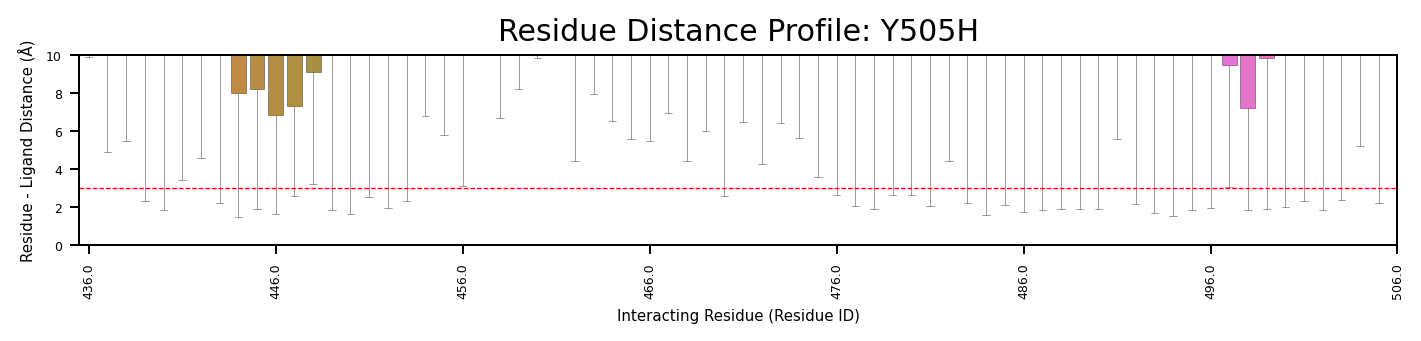

In [6]:
for x in os.listdir(dirpath):
    if os.path.isdir(os.path.join(dirpath,x)):
        if not any(["BFACTORS" in os.path.join(dirpath,x), "RMSF" in os.path.join(dirpath,x)]):
            active_dir_rr = os.path.join(dirpath,x)
            tpr_files_rr = glob.glob(os.path.join(active_dir_rr,"*minimization.tpr"))
            xtc_files_rr = glob.glob(os.path.join(active_dir_rr,"*mdout.xtc"))
            savepath_rr = "/Users/junealexissantos/Documents/MS Research Data/savepath"
            a = calculate_distance(xtc_files_rr[0], tpr_files_rr[0], save=True, savepath=savepath_rr, 
                       runtime_title = os.path.basename(active_dir_rr).split("_")[-1])